# Capstone Week 2 - Battle of the Neighborhoods - VooDoo Doughnut
# Shall VooDoo Dougnut Open New Locations in Manhattan, NY and Toronto, ON?

## TORONTO

In [1]:
import pandas as pd # library to process data as dataframes
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import these for kmeans elbow method
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# import for silhouette score
from sklearn.metrics import silhouette_score

!conda install -c conda-forge folium=0.5.0 --yes # needed for Foursquare API
import folium # map rendering library


print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


### Get the page with the Toronto neighborhoods from Wikipedia

https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M


In [2]:
#read in the Wikipedia article to get a local copy

import urllib.request

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
req = urllib.request.urlopen(url)
article = req.read().decode()

with open('ISO_3166-1_alpha-2.html', 'w') as fo:
    fo.write(article)

### This section will screen scrape the Toronto Wikipedia page using BeautifulSoup

In [3]:
!pip install beautifulsoup4 # install beautifulsoup4 to scrape website tables
from bs4 import BeautifulSoup

In [4]:
# Load article, turn into soup and get the <table>s.
article = open('ISO_3166-1_alpha-2.html').read()
soup = BeautifulSoup(article, 'html.parser')
tables = soup.find_all('table', class_='sortable')

In [5]:
# Search through the tables for the table with the headings we want.
for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[:5] == ['Postcode', 'Borough', 'Neighborhood']:
        break

In [6]:
# Extract the columns we want and write to a semicolon-delimited text file.
with open('iso_3166-1_alpha-2_codes.txt', 'w') as fo:
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        if not tds:
            continue
        postcode, borough, neighborhood = [td.text.strip() for td in tds[:3]]
        print('; '.join([postcode, borough, neighborhood]), file=fo) # write the data to a text file

### Put the table into a dataframe

In [7]:
# read the text file containing the table into a dataframe
df = pd.read_csv('iso_3166-1_alpha-2_codes.txt', sep=';', header=None, names=['PostalCode', 'Borough', 'Neighborhood'])

### Dataframe cleanup

### Drop the rows where 'Borough' is 'Not assigned'

In [8]:
# drop the rows where 'Borough' is 'Not assigned' and put the remaining rows into a new dataframe
df_assigned_borough = df[df['Borough'].str.contains('Not assigned') == False].copy()


### If Neighborhood is "Not assigned", put the value of Borough into Neighborhood

In [9]:
# This changes Neighborhood to the value of Borough if Neighborhood = " Not assigned"
df_assigned_borough['Neighborhood'] = np.where((df_assigned_borough['Neighborhood'] == " Not assigned"), df_assigned_borough['Borough'],df_assigned_borough['Neighborhood'])

### Group the neighborhoods having the same postcode and borough

In [10]:
#Group the neighborhoods having the same postcode and borough
df_grouped_neighborhoods = df_assigned_borough.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: "%s" % ', '.join(x)).to_frame().reset_index()



### This section will add the geographical coordinates to the dataframe

### Read in the file with the geographical coordinates

In [11]:
coordinates = pd.read_csv("https://cocl.us/Geospatial_data") #read in the geographical coordinates file

### Merge the df_grouped_neighborhoods dataframe with the coordinates dataframe

In [12]:
df_merged_with_coordinates = pd.merge(df_grouped_neighborhoods, coordinates, left_on='PostalCode', right_on='Postal Code').copy()

In [13]:
del df_merged_with_coordinates['Postal Code'] #remove the redundant Postal Code column

###  Explore and cluster the neighborhoods in Toronto

In [14]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
toronto_latitude = latitude
toronto_longitude = longitude
#print('The geographical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merged_with_coordinates['Latitude'], df_merged_with_coordinates['Longitude'], df_merged_with_coordinates['Borough'], df_merged_with_coordinates['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### For exploring and clustering, We will be working only with the boroughs containing the word Toronto

In [16]:
#Get all the cells with borough containing "Toronto"
toronto_data = df_merged_with_coordinates[df_merged_with_coordinates['Borough'].str.contains ('Toronto')].reset_index(drop=True)


In [17]:
# create map of boroughs with "Toronto" in the name using latitude and longitude values
map_toronto_boroughs = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_boroughs)  
    
map_toronto_boroughs

### Utilize the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'HN1NJCEXITXRABMGWQSIG2YF55DZXS1BD1FIDEWZVT5AHQWJ' # your Foursquare ID
CLIENT_SECRET = 'DFHRVMNLGGJRTXEPREPJ34IDSJIVB5CN3OZZO5LK5O5RBLHF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HN1NJCEXITXRABMGWQSIG2YF55DZXS1BD1FIDEWZVT5AHQWJ
CLIENT_SECRET:DFHRVMNLGGJRTXEPREPJ34IDSJIVB5CN3OZZO5LK5O5RBLHF


In [19]:
address = "22 SW 3rd Avenue Portland, OR"
geolocator = Nominatim(user_agent="my_explorer")
VooDoo = None
while(VooDoo == None):
    VooDoo = geolocator.geocode(address)
latitude = VooDoo.latitude
longitude = VooDoo.longitude
#print('The geographical coordinates of VooDoo Doughnut are {}, {}.'.format(latitude, longitude))

In [20]:
cols = ['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']
portland_voodoo_df = pd.DataFrame([['97204', 'VooDoo', 'VooDoo', latitude, longitude]], columns = cols)
toronto_data = toronto_data.append(portland_voodoo_df, ignore_index=True, sort=False)


#### Create a function to get the top 100 venues that are within a radius of 500 meters of each Toronto neighborhood

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)        

In [22]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

### Analyze Each Neighborhood

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]


### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
#toronto_grouped

### Put the data into a pandas dataframe

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)



### Cluster Neighborhoods

In [27]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

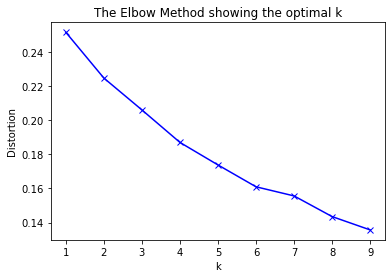

In [28]:
# determing optimal number of clusters

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [29]:
#Use silhouette score
score_array = np.array([])
range_n_clusters = list (range(2,7))
print ("Number of clusters from 2 to 6: \n", range_n_clusters)
dist_index = 0

for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters,random_state=0)
    preds = clusterer.fit_predict(toronto_grouped_clustering)
    centers = clusterer.cluster_centers_

    dist_index = n_clusters - 1
    score = silhouette_score (toronto_grouped_clustering, preds, metric='euclidean')
    score_array = np.append(score_array,[score], axis=0)

#    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

Number of clusters from 2 to 6: 
 [2, 3, 4, 5, 6]


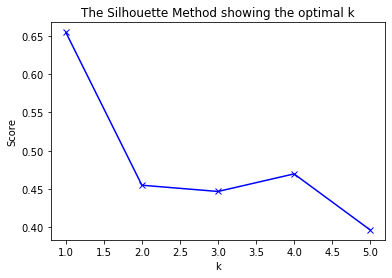

In [30]:
# k means determine k
K = range(1,6)
# Plot the silhouette
plt.plot(K, score_array, 'bx-')
#plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('Score')
plt.title('The Silhouette Method showing the optimal k')
plt.show()

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


### visualize the resulting clusters on a map

In [32]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Health Food Store,Trail,Pub,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
1,East Toronto,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Restaurant,Brewery,Bubble Tea Shop,Pub
2,East Toronto,0,Park,Sushi Restaurant,Ice Cream Shop,Board Shop,Sandwich Place,Brewery,Burger Joint,Fast Food Restaurant,Burrito Place,Fish & Chips Shop
3,East Toronto,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Comfort Food Restaurant,Bookstore,Seafood Restaurant,Sandwich Place,Brewery
5,Central Toronto,0,Gym,Hotel,Pizza Place,Clothing Store,Convenience Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Park,General Entertainment
6,Central Toronto,0,Sporting Goods Shop,Coffee Shop,Clothing Store,Yoga Studio,Rental Car Location,Diner,Spa,Dessert Shop,Salon / Barbershop,Burger Joint
7,Central Toronto,0,Pizza Place,Dessert Shop,Sandwich Place,Coffee Shop,Gym,Italian Restaurant,Café,Sushi Restaurant,Park,Seafood Restaurant
9,Central Toronto,0,Pub,Coffee Shop,American Restaurant,Liquor Store,Sports Bar,Restaurant,Bagel Shop,Supermarket,Sushi Restaurant,Fried Chicken Joint
11,Downtown Toronto,0,Coffee Shop,Restaurant,Chinese Restaurant,Pizza Place,Park,Pub,Market,Café,Italian Restaurant,Bakery
12,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Hotel,Gastropub,Men's Store,Café,Mediterranean Restaurant


### Cluster 2

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,1,Gym,Playground,Wings Joint,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


### Cluster 3

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,2,Garden,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Cluster 4

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,3,Park,Playground,Trail,Wings Joint,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
23,Central Toronto,3,Park,Sushi Restaurant,Trail,Jewelry Store,Wings Joint,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run


### Cluster 5

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,4,Bus Line,Park,Swim School,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [38]:
toronto_merged.to_csv('Week3_Part3_toronto_merged.csv', sep=',', encoding='utf-8') #copy dataframe to csv

## Manhattan

### Get the New York data

In [39]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [40]:
neighborhoods_data = newyork_data['features']

In [41]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_neighborhoods = pd.DataFrame(columns=column_names)

In [42]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [43]:
manhattan_data = NY_neighborhoods[NY_neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
#manhattan_data.head()

In [44]:
manhattan_data = manhattan_data.append(portland_voodoo_df, ignore_index=True, sort=False)

#### Use geopy library to get the latitude and longitude values of Manhattan.

In [45]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geographical coordinates of Manhattan are {}, {}.'.format(latitude, longitude))

In [46]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [47]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

#print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
#                                                               neighborhood_latitude, 
#                                                               neighborhood_longitude))

In [48]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

### Analyze Each Neighborhood

In [49]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

#manhattan_onehot.head()

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [50]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
#manhattan_grouped

In [51]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)


### Cluster Manhattan Neighborhoods

In [52]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 1, 1, 2, 2, 0, 1, 2], dtype=int32)

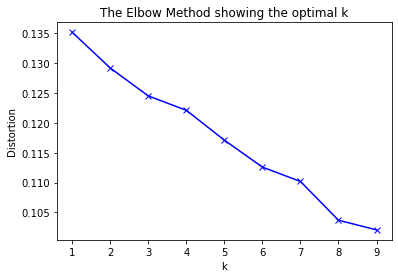

In [53]:
# determing optimal number of clusters using elbow method

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(manhattan_grouped_clustering)
    distortions.append(sum(np.min(cdist(manhattan_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / manhattan_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [54]:
#Use silhouette score
score_array = np.array([])
range_n_clusters = list (range(2,12))
#print ("Number of clusters from 2 to 11: \n", range_n_clusters)
dist_index = 0

for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters,random_state=0)
    preds = clusterer.fit_predict(manhattan_grouped_clustering)
    centers = clusterer.cluster_centers_

    dist_index = n_clusters - 1
    score = silhouette_score (manhattan_grouped_clustering, preds, metric='euclidean')
    score_array = np.append(score_array,[score], axis=0)

#    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

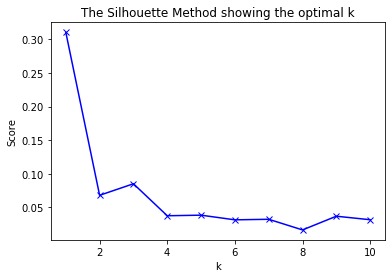

In [55]:
# k means determine k
K = range(1,11)
# Plot the silhouette
plt.plot(K, score_array, 'bx-')
#plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('Score')
plt.title('The Silhouette Method showing the optimal k')
plt.show()

In [56]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')



In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

#### Cluster 1

In [58]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,0,Mobile Phone Shop,Café,Bakery,Grocery Store,Pizza Place,Spanish Restaurant,Supermarket,Supplement Shop,Sandwich Place,Tapas Restaurant
3,Inwood,0,Lounge,Mexican Restaurant,Café,Restaurant,Bakery,Frozen Yogurt Shop,Caribbean Restaurant,Chinese Restaurant,Spanish Restaurant,Park
4,Hamilton Heights,0,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega,Park,Caribbean Restaurant,Chinese Restaurant,School,Bakery
5,Manhattanville,0,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Liquor Store,Park,Italian Restaurant,Seafood Restaurant,Food & Drink Shop,Spanish Restaurant
7,East Harlem,0,Mexican Restaurant,Bakery,Deli / Bodega,Thai Restaurant,Latin American Restaurant,Pharmacy,Cuban Restaurant,Cocktail Bar,Steakhouse,Beer Bar
11,Roosevelt Island,0,Sandwich Place,Park,Cosmetics Shop,Liquor Store,Supermarket,Metro Station,Bus Line,Soccer Field,Farmers Market,School
26,Morningside Heights,0,Park,American Restaurant,Bookstore,Coffee Shop,Sandwich Place,Deli / Bodega,Food Truck,Burger Joint,Ethiopian Restaurant,Supermarket
36,Tudor City,0,Park,Café,Mexican Restaurant,Greek Restaurant,Pizza Place,Deli / Bodega,Diner,Sushi Restaurant,Gym,Asian Restaurant


#### Cluster 2

In [59]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,1,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Cocktail Bar,Optical Shop,Salon / Barbershop,Bakery,Spa,Dumpling Restaurant,Furniture / Home Store
8,Upper East Side,1,Italian Restaurant,Exhibit,Bakery,Art Gallery,Coffee Shop,Hotel,Cocktail Bar,Gym / Fitness Center,French Restaurant,Boutique
9,Yorkville,1,Italian Restaurant,Coffee Shop,Bar,Gym,Pizza Place,Deli / Bodega,Wine Shop,Ice Cream Shop,Japanese Restaurant,Sandwich Place
10,Lenox Hill,1,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Gym,Café,Cocktail Bar,Burger Joint,Sporting Goods Shop,Gym / Fitness Center
12,Upper West Side,1,Italian Restaurant,Coffee Shop,Wine Bar,Bar,Café,Mediterranean Restaurant,Bakery,Cosmetics Shop,Indian Restaurant,Vegetarian / Vegan Restaurant
17,Chelsea,1,Coffee Shop,Bakery,Italian Restaurant,Ice Cream Shop,Nightclub,Seafood Restaurant,American Restaurant,Hotel,Theater,Pizza Place
18,Greenwich Village,1,Italian Restaurant,Sushi Restaurant,Clothing Store,Boutique,Indian Restaurant,French Restaurant,Café,Cosmetics Shop,Seafood Restaurant,Burger Joint
19,East Village,1,Bar,Chinese Restaurant,Wine Bar,Ice Cream Shop,Mexican Restaurant,Cocktail Bar,Pizza Place,Vegetarian / Vegan Restaurant,Coffee Shop,Ramen Restaurant
20,Lower East Side,1,Pizza Place,Café,Art Gallery,Japanese Restaurant,Coffee Shop,Bakery,Ramen Restaurant,Chinese Restaurant,Cocktail Bar,Clothing Store
22,Little Italy,1,Bakery,Café,Sandwich Place,Salon / Barbershop,Bubble Tea Shop,Mediterranean Restaurant,Spa,Clothing Store,Chinese Restaurant,Italian Restaurant


#### Cluster 3

In [60]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Central Harlem,2,African Restaurant,Seafood Restaurant,Bar,American Restaurant,Cosmetics Shop,Fried Chicken Joint,French Restaurant,Chinese Restaurant,Café,Library
13,Lincoln Square,2,Theater,Plaza,Café,Italian Restaurant,Concert Hall,Gym / Fitness Center,Performing Arts Venue,Indie Movie Theater,French Restaurant,Park
14,Clinton,2,Theater,Gym / Fitness Center,American Restaurant,Italian Restaurant,Coffee Shop,Wine Shop,Gym,Hotel,Sandwich Place,French Restaurant
15,Midtown,2,Hotel,Theater,Sporting Goods Shop,Coffee Shop,Clothing Store,Spa,Bakery,Bookstore,Steakhouse,Food Truck
16,Murray Hill,2,Coffee Shop,Hotel,Sandwich Place,Japanese Restaurant,American Restaurant,Gym / Fitness Center,Gym,Italian Restaurant,Mediterranean Restaurant,Bakery
21,Tribeca,2,American Restaurant,Park,Italian Restaurant,Café,Wine Shop,Spa,Greek Restaurant,Wine Bar,Coffee Shop,Men's Store
24,West Village,2,Italian Restaurant,New American Restaurant,Jazz Club,American Restaurant,Wine Bar,Park,Cosmetics Shop,Cocktail Bar,Bakery,Coffee Shop
28,Battery Park City,2,Park,Coffee Shop,Hotel,Gym,Wine Shop,Memorial Site,Boat or Ferry,Pizza Place,Italian Restaurant,Women's Store
29,Financial District,2,Coffee Shop,American Restaurant,Pizza Place,Wine Shop,Hotel,Steakhouse,Gym / Fitness Center,Gym,Cocktail Bar,Italian Restaurant
32,Civic Center,2,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Hotel,French Restaurant,Yoga Studio,Sandwich Place,Cocktail Bar,Park,Spa


#### Cluster 4

In [61]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,3,Sandwich Place,Coffee Shop,Yoga Studio,Tennis Stadium,Supplement Shop,Steakhouse,Miscellaneous Shop,Shopping Mall,Seafood Restaurant,Donut Shop


#### Cluster 5

In [62]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,4,Bar,Playground,Park,Boat or Ferry,German Restaurant,Basketball Court,Baseball Field,Gym / Fitness Center,Cocktail Bar,Coffee Shop


## Observations/Analysis

### The data indicate that VooDoo Doughnut fits in the Toronto Cluster 1 (Label 0) and in the Manhattan Cluster 3 (Label 2).  For Manhattan, VooDoo Doughnut will probably also fit in Cluster 2 (Label 1), since there are a high number of coffee shops in that cluster.  There was no optimal number of clusters for either Manhattan or Toronto.  For each location, the Elbow and Silhouette method were used, but were inconclusive.  Therefore, 5 clusters were used for both Manhattan and Toronto.